In [2]:
import os

imdb_dir = './datasets/aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), encoding='utf8')
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

In [3]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 100  # 100개 단어 이후는 버립니다
training_samples = 200  # 훈련 샘플은 200개입니다
validation_samples = 10000  # 검증 샘플은 10,000개입니다
max_words = 10000  # 데이터셋에서 가장 빈도 높은 10,000개의 단어만 사용합니다

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('%s개의 고유한 토큰을 찾았습니다.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('데이터 텐서의 크기:', data.shape)
print('레이블 텐서의 크기:', labels.shape)

# 데이터를 훈련 세트와 검증 세트로 분할합니다.
# 샘플이 순서대로 있기 때문에 (부정 샘플이 모두 나온 후에 긍정 샘플이 옵니다) 
# 먼저 데이터를 섞습니다.
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

88582개의 고유한 토큰을 찾았습니다.
데이터 텐서의 크기: (25000, 100)
레이블 텐서의 크기: (25000,)


In [4]:
glove_dir = './datasets/'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'), encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('%s개의 단어 벡터를 찾았습니다.' % len(embeddings_index))

400000개의 단어 벡터를 찾았습니다.


In [5]:
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            # 임베딩 인덱스에 없는 단어는 모두 0이 됩니다.
            embedding_matrix[i] = embedding_vector

In [6]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          1000000   
_________________________________________________________________
flatten (Flatten)            (None, 10000)             0         
_________________________________________________________________
dense (Dense)                (None, 32)                320032    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [7]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [8]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')

Epoch 1/10
7/7 [==============================] - 2s 285ms/step - loss: 2.2450 - acc: 0.4513 - val_loss: 0.7344 - val_acc: 0.5034
Epoch 2/10
7/7 [==============================] - 0s 66ms/step - loss: 0.5729 - acc: 0.6830 - val_loss: 0.8048 - val_acc: 0.5035
Epoch 3/10
7/7 [==============================] - 0s 70ms/step - loss: 0.4507 - acc: 0.7833 - val_loss: 0.6894 - val_acc: 0.5430
Epoch 4/10
7/7 [==============================] - 0s 65ms/step - loss: 0.3281 - acc: 0.9563 - val_loss: 1.0531 - val_acc: 0.5035
Epoch 5/10
7/7 [==============================] - 0s 71ms/step - loss: 0.3519 - acc: 0.8288 - val_loss: 0.7839 - val_acc: 0.5165
Epoch 6/10
7/7 [==============================] - 0s 66ms/step - loss: 0.1842 - acc: 0.9784 - val_loss: 0.8064 - val_acc: 0.5298
Epoch 7/10
7/7 [==============================] - 0s 71ms/step - loss: 0.1704 - acc: 0.9908 - val_loss: 0.7170 - val_acc: 0.5643
Epoch 8/10
7/7 [==============================] - 0s 67ms/step - loss: 0.0795 - acc: 0.9949 - va

In [9]:
import matplotlib.pyplot as plt

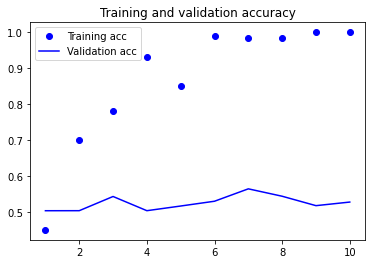

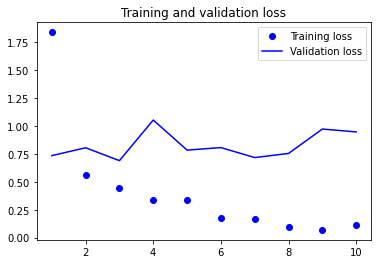

In [10]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [11]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
7/7 [==============================] - 1s 103ms/step - loss: 0.6941 - acc: 0.5206 - val_loss: 0.6930 - val_acc: 0.5144
Epoch 2/10
7/7 [==============================] - 0s 72ms/step - loss: 0.5264 - acc: 0.9901 - val_loss: 0.6938 -

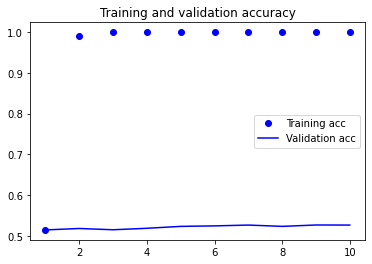

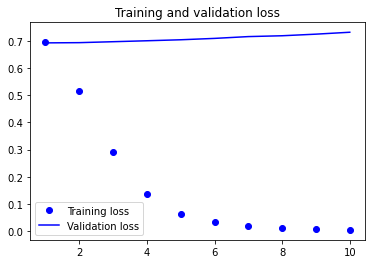

In [12]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [13]:
training_samples = 2000
x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

In [14]:
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

Epoch 1/10
63/63 [==============================] - 1s 15ms/step - loss: 0.6458 - acc: 0.5915 - val_loss: 0.6369 - val_acc: 0.6297
Epoch 2/10
63/63 [==============================] - 1s 15ms/step - loss: 0.1839 - acc: 0.9840 - val_loss: 0.5959 - val_acc: 0.6845
Epoch 3/10
63/63 [==============================] - 1s 14ms/step - loss: 0.0253 - acc: 0.9995 - val_loss: 0.6032 - val_acc: 0.7058
Epoch 4/10
63/63 [==============================] - 1s 14ms/step - loss: 0.0022 - acc: 1.0000 - val_loss: 0.6594 - val_acc: 0.7148
Epoch 5/10
63/63 [==============================] - 1s 14ms/step - loss: 1.5693e-04 - acc: 1.0000 - val_loss: 0.7073 - val_acc: 0.7258
Epoch 6/10
63/63 [==============================] - 1s 14ms/step - loss: 8.5891e-06 - acc: 1.0000 - val_loss: 0.8324 - val_acc: 0.7205
Epoch 7/10
63/63 [==============================] - 1s 14ms/step - loss: 8.0710e-07 - acc: 1.0000 - val_loss: 0.8518 - val_acc: 0.7280
Epoch 8/10
63/63 [==============================] - 1s 15ms/step - loss

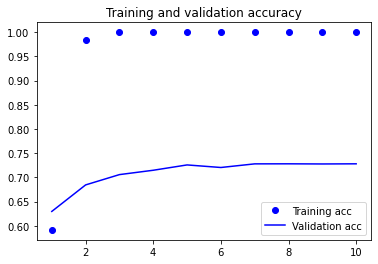

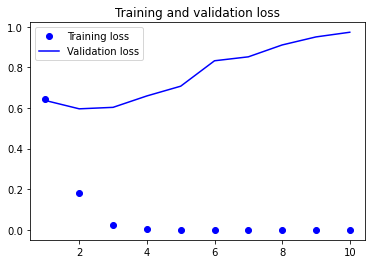

In [15]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [16]:
test_dir = os.path.join(imdb_dir, 'test')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), encoding="utf8")
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)

In [17]:
model.load_weights('pre_trained_glove_model.h5')
model.evaluate(x_test, y_test)

782/782 [==============================] - 1s 2ms/step - loss: 0.9474 - acc: 0.5225


[0.9474034905433655, 0.5224800109863281]